## Introduction to the Interstellar Medium
### Jonathan Williams

### Figure 7.8: map 353 GHz (850 micron) polarized dust continuum toward the Rosette cloud

#### observations taken with the Planck satellite
#### published by Alves et al. 2006 (https://ui.adsabs.harvard.edu/abs/2016A%26A...586A.137P)
#### data and a template mapping script provided by Marta Alves

In [8]:
import numpy as np
import math
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import (ImageNormalize, SqrtStretch, LogStretch, AsinhStretch)
%matplotlib inline

    Header size is not multiple of 2880: 1
There may be extra bytes after the last HDU or the file is corrupted. [astropy.io.fits.hdu.hdulist]


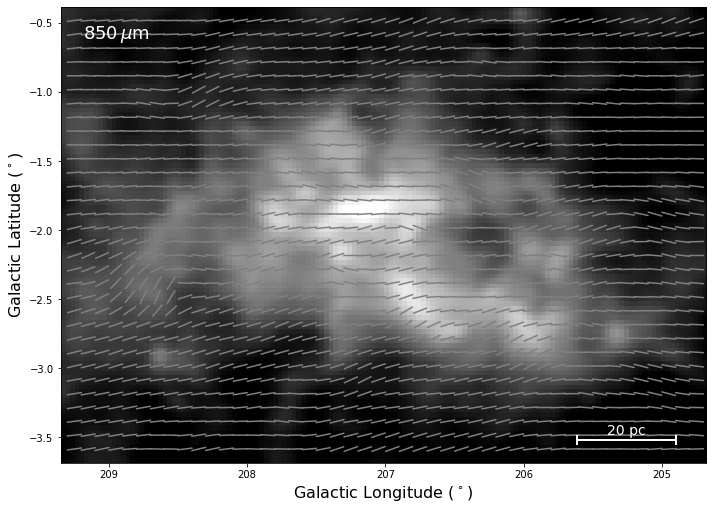

In [9]:
fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(111)

hduI = fits.open('rosette_planck_353GHz_I.fits', ignore_missing_end=True)
hdu_cmb = fits.open('rosette_planck_353GHz_cmb.fits', ignore_missing_end=True)

# CO contribution to CMB (this comes from analysis by the Planck team)
cib_mono = 0.0885
cib_mono_sigma = 0.0067

im353 = hduI[0].data - hdu_cmb[0].data - cib_mono

# scale factor between Kelvin to MJy/steradian
scale = 287.2262
im353 *= scale

hd = hduI[0].header
nx = hd['NAXIS1']
ny = hd['NAXIS2']
x0 = hd['CRVAL1']
y0 = hd['CRVAL2']
dx = hd['CDELT1']
dy = hd['CDELT2']
i0 = hd['CRPIX1']
j0 = hd['CRPIX2']

# manually crop
imin, imax = 20,160
jmin, jmax = 40,139
nx = imax-imin+1
ny = jmax-jmin+1
x = x0 + (imin+np.arange(nx)-i0)*dx
y = y0 + (jmin+np.arange(ny)-j0)*dy
extent = [x.max(), x.min(), y.min(), y.max()]
imcrop = im353[jmin:jmax, imin:imax]
#print(imcrop.min(), imcrop.max())

norm = ImageNormalize(imcrop, stretch=AsinhStretch(), vmin=-22, vmax=0)
ax.imshow(imcrop, cmap='gray', origin='lower', extent=extent, norm=norm)
ax.text(0.035,0.93,r'$850\,\mu$m', {'color': 'w', 'fontsize': 18}, transform=ax.transAxes)
ax.set_xlabel(r'Galactic Longitude ($^\circ$)', fontsize=16)
ax.set_ylabel(r'Galactic Latitude ($^\circ$)', fontsize=16)

hduI.close()
hdu_cmb.close()


# get polarization vectors
hduQ = fits.open('rosette_planck_353GHz_Q.fits', ignore_missing_end=True)
hduU = fits.open('rosette_planck_353GHz_U.fits', ignore_missing_end=True)

q = hduQ[0].data[jmin:jmax, imin:imax]
u = hduU[0].data[jmin:jmax, imin:imax]
hduQ.close()
hduU.close()

# vector size
s = 0.05

# follow Alves IDL code
pfrac = 3
pdelt = 3
nxf = int(nx/pfrac)
nyf = int(ny/pfrac)

for j0 in range(nyf):
    j1 = j0*pfrac + pdelt
    if j1 > 0 and j1 < ny-1:
        jmin1 = (j1 - pdelt)
        jmax1 = (j1 + pdelt)
        y1 = y[j1]
        for i0 in range(nxf):
            i1 = i0*pfrac + pdelt
            if i1 > 0 and i1 < nx-1:
                imin1 = (i1 - pdelt)
                imax1 = (i1 + pdelt)
                x1 = x[i1]

                qmean = np.mean(q[jmin1:jmax1, imin1:imax1])
                umean = np.mean(u[jmin1:jmax1, imin1:imax1])
                psi = 0.5*math.atan2(-umean,qmean)
                ax.plot([x1+s*math.cos(psi), x1-s*math.cos(psi)], [y1-s*math.sin(psi), y1+s*math.sin(psi)], color='gray', linewidth=1.5)

# scale bar
xbar = (20/1600)*180/np.pi
x0 = 204.9
x1 = x0 + xbar
y0 = -3.52
dy = 0.03
ax.plot([x0,x1],[y0,y0], 'w-', lw=2)
ax.plot([x0,x0],[y0-dy,y0+dy], 'w-', lw=2)
ax.plot([x1,x1],[y0-dy,y0+dy], 'w-', lw=2)
ax.text(0.5*(x0+x1), y0+1.5*dy, '20 pc', color='white', fontsize=14, ha='center')

plt.tight_layout()
plt.savefig('rosette_polarization.pdf')